In [25]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.image as mpimg


def phantom(t, params):

    a = params[0]
    n = params[1]

    if t==0:

        f = np.array(mpimg.imread('lemon_only.png'))[0:256:2,0:256:2]

    elif t==1:

        # norma-2 (circulo)
        
        x = np.linspace(-a,a,n)    
        xx,yy = np.meshgrid(x,x)

        f = (xx**2 + yy**2 < 0.3**2).astype(np.double)

    elif t==2:

        # norma-1 (losango)
        
        x = np.linspace(-a,a,n)    
        xx,yy = np.meshgrid(x,x)

        f = ( np.abs(xx) + np.abs(yy) < 0.3 ).astype(np.double)

    else:

        # norma-p ( `quadrado`, p->infty)
        
        p = 10
        
        x = np.linspace(-a,a,n)    
        xx,yy = np.meshgrid(x,x)

        f = ( np.abs(xx)**p + np.abs(yy)**p < 0.3**p ).astype(np.double)
        
        
    return f

In [2]:
def radon(img, params):

    a = params[0] # range (radius)
    size = params[1]
    angles = params[2]
    initial_angle = params[3]
    final_angle = params[4]
    
    t  = np.linspace(-a, a, size)
    theta = np.linspace( (np.pi * initial_angle / 180.0), (np.pi * final_angle / 180.0), angles, endpoint=False) 
    s  = np.linspace(-a, a, size)

    sino = np.zeros([size, angles])

    dx = 2.*a/(size - 1)
    dy = dx
    
    for i in range(size):

        for j in range(angles):
            
            for k in range(size):

                x = t[i] * np.cos(theta[j]) - s[k] * np.sin(theta[j])
                y = t[i] * np.sin(theta[j]) + s[k] * np.cos(theta[j])
        
                ix = ( np.ceil( (x + a)/dx) ).astype(np.int)
                iy = ( np.ceil( (y + a)/dy) ).astype(np.int)

                if ((ix > 0) & (ix < size) & (iy >0) & (iy < size)):         
                    sino[i][j] += img[ix][iy]
                    
    return sino

$f_\theta(x,y)=g(x\cos{\theta}+y\sin{\theta}, \theta)$  
$f(x,y)=\int_0^\pi{f_\theta(x,y)d\theta}$  
$f(x,y)=\sum\limits_{\theta=0}^\pi{f_\theta(x,y)}$

In [14]:
def backprojection(sino, params):

    a = params[0] # range (radius)
    size = params[1]
    angles = params[2]
    initial_angle = params[3]
    final_angle = params[4]
    
    theta = np.linspace((np.pi * initial_angle / 180.0), (np.pi * final_angle / 180.0), angles, endpoint=False)
    
    x = np.linspace(-a, a, size)
    y = x

    dt = (2*a)/(size-1)

    b = np.zeros([size, size])
    
    for i in range(size):
        for j in range(size):

            cumsum = 0

            for k in range(angles):

                t = x[i] * np.cos(theta[k]) + y[j] * np.sin(theta[k])

                idx = np.ceil((t + a)/dt).astype(np.int) 

                if ((idx > 0) & (idx < size)):
                    cumsum += sino[idx, k]

            b[i, j] = cumsum

    return b

In [41]:
def filter(sinogram, params):

    a = params[0] # range (radius)
    size = params[1]
    angles = params[2]
    initial_angle = params[3]
    final_angle = params[4]
    
    theta = np.linspace((np.pi * initial_angle / 180.0), (np.pi * final_angle / 180.0), angles, endpoint=False)
    t  = np.linspace(-a, a, size)
    
    dt = (2*a)/(size-1)
    
    wc = 1.0/(2*dt)
    
    w = np.linspace(-wc, wc, size)
    
    # Filtro rampa
    h = np.abs(w)
    
    # Aqui eu faço o shift no filtro, porque a imagem está sem a translação
    G = np.fft.fftshift(np.transpose(np.kron(np.ones((angles, 1)), h)))
    
    B = np.fft.fft(sinogram, axis=0)
    
    # Multiplicação de imagem com filtro no domínio da frequência = convolução no domínio do espaço
    C = B * G
    
    D = np.fft.ifft(C, axis=0)

    # Plotando só para mostrar o filtro
    plt.plot(np.fft.fftshift(G))
    plt.show()
    return D.real 

In [10]:
def shift_slice(img, rr, cc):
    
    f = np.array(img)
    r, c = f.shape

    c1 = cc%c
    r1 = rr%r
    g = np.concatenate(( np.concatenate((f[r-r1:,c-c1:], f[r-r1:,:c-c1]), axis=1) , \
                         np.concatenate((f[:r-r1, c-c1:], f[:r-r1, :c-c1]), axis=1) ))

    return g

In [11]:
def show_fourier(F):
    F_final = (np.log(np.abs(shift_slice(F,F.shape[0]//2,f.shape[1]//2)+1)))
    F_final *= 1.0/F_final.max() 
    plt.figure(figsize=[10,10])
    plt.imshow(F_final, cmap='gray')
    plt.show()
    return F_final

In [ ]:
params = ( 1.0,128, 180, 0, 180)

CPU times: user 1min 8s, sys: 0 ns, total: 1min 8s
Wall time: 1min 8s


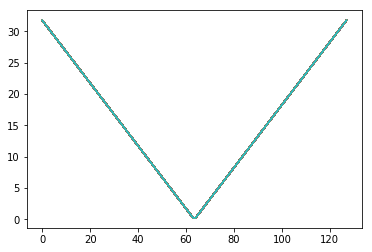

CPU times: user 34.5 s, sys: 60.1 ms, total: 34.5 s
Wall time: 34.4 s
CPU times: user 34.5 s, sys: 0 ns, total: 34.5 s
Wall time: 34.5 s


In [50]:
f = phantom(0, params)

%time sinogram = radon(f, params)

h = filter(sinogram, params)

%time b = backprojection(h, params)

%time b_unfiltered = backprojection(sinogram, params)

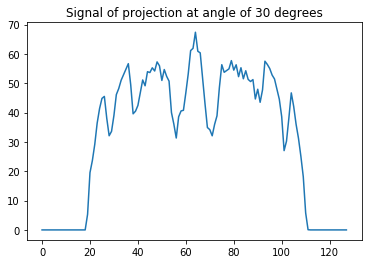

In [56]:
plt.plot(sinogram[:,30])
plt.title('Signal of projection at angle of 30 degrees')
plt.show()

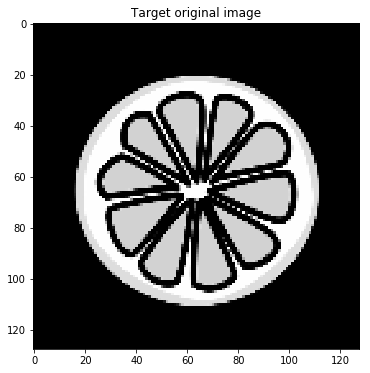

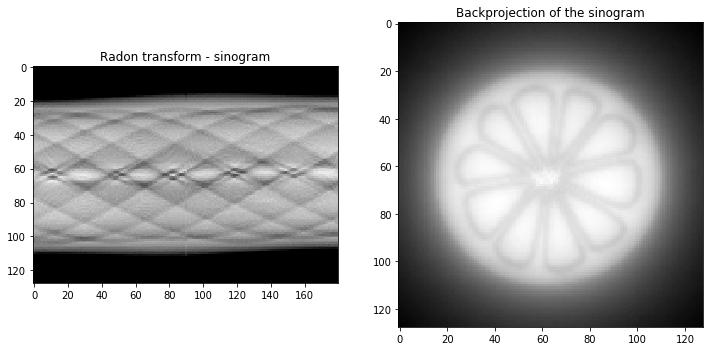

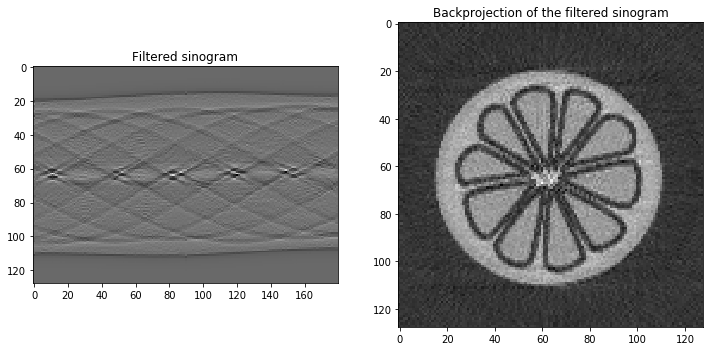

In [55]:
plt.figure(figsize=[6,6])
plt.title('Target original image')
plt.imshow(f, cmap='gray')
plt.show()

plt.figure(figsize=[12, 10])
plt.subplot(121)
plt.title('Radon transform - sinogram')
plt.imshow(sinogram, cmap='gray')

plt.subplot(122)
plt.title('Backprojection of the sinogram')
plt.imshow(b_unfiltered, cmap='gray')
plt.show()

plt.figure(figsize=[12, 10])
plt.subplot(121)
plt.title('Filtered sinogram')
plt.imshow(h, cmap='gray')

plt.subplot(122)
plt.title('Backprojection of the filtered sinogram')
plt.imshow(b, cmap='gray')

plt.show()

In [66]:
# ia.normalize
def normalize(f, range=[0,255]):

    f = np.asarray(f)
    range = np.asarray(range)
    if f.dtype.char in ['D', 'F']:
        raise Exception('error: cannot normalize complex data')
    faux = np.ravel(f).astype(float)
    minimum = faux.min()
    maximum = faux.max()
    lower = range[0]
    upper = range[1]
    if upper == lower:
        g = np.ones(f.shape) * maximum
    if minimum == maximum:
        g = np.ones(f.shape) * (upper + lower) / 2.
    else:
        g = (faux-minimum)*(upper-lower) / (maximum-minimum) + lower
    g = g.reshape(f.shape)

    if f.dtype == np.uint8:
        if upper > 255: 
            raise Exception('normalize: warning, upper valuer larger than 255. Cannot fit in uint8 image')
    if lower == 0 and upper == 255:
        g = g.astype(np.uint8)
    else:
        g = g.astype(f.dtype) # set data type of result the same as the input image
    return g


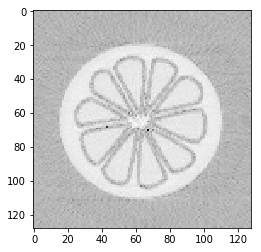

In [67]:
T = np.arange(256).astype('uint8')
T2 = normalize(np.log(T+1.))

b2 = normalize(b)
plt.imshow(T2[b2], cmap='gray')
plt.show()

### Fourier Slice Theorem
Source: https://dsp.stackexchange.com/a/3602

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


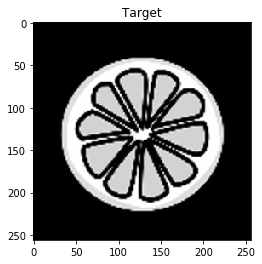

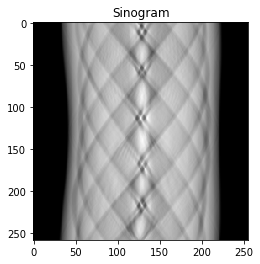

/usr/local/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


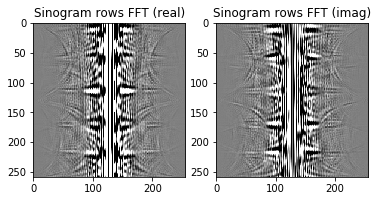

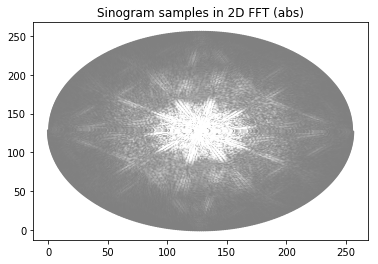

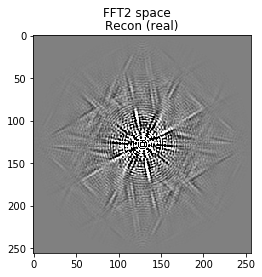

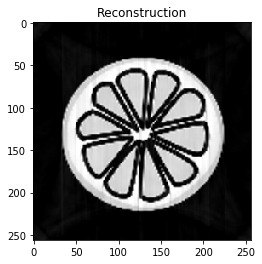

In [57]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import scipy.interpolate
import scipy.fftpack
import scipy.misc
import scipy.ndimage.interpolation

S=256 # Size of target, and resolution of Fourier space
N=259 # Number of sinogram exposures (odd number avoids redundant direct opposites)

V=100 # Range on fft plots

# Convenience function
def sqr(x): return x*x

# Return the angle of the i-th (of 0-to-N-1) sinogram exposure in radians.
def angle(i): return (math.pi*i)/N

# Prepare a target image
x,y=np.meshgrid(np.arange(S)-S/2,np.arange(S)-S/2)
mask=(sqr(x)+sqr(y)<=sqr(S/2-10))
target=np.where(
    mask,
    scipy.misc.imresize(
        f,
        (S,S),
        interp='cubic'
        ),
    np.zeros((S,S))
    )/255.0

plt.figure()
plt.title("Target")
plt.imshow(target)
plt.gray()

# Project the sinogram (ie calculate Radon transform)
sinogram=np.array([
        np.sum(
            scipy.ndimage.interpolation.rotate(
                target,
                np.rad2deg(angle(i)), # NB rotate takes degrees argument
                order=3,
                reshape=False,
                mode='constant',
                cval=0.0
                )
            ,axis=0
            ) for i in range(N)
        ])

plt.figure()
plt.title("Sinogram")
plt.imshow(sinogram, cmap='gray')
plt.show()

# Fourier transform the rows of the sinogram, move the DC component to the row's centre
sinogram_fft_rows=scipy.fftpack.fftshift(
    scipy.fftpack.fft(
        scipy.fftpack.ifftshift(
            sinogram,
            axes=1
            )
        ),
    axes=1
    )

plt.figure()
plt.subplot(121)
plt.title("Sinogram rows FFT (real)")
plt.imshow(np.real(sinogram_fft_rows),vmin=-V,vmax=V)
plt.subplot(122)
plt.title("Sinogram rows FFT (imag)")
plt.imshow(np.imag(sinogram_fft_rows),vmin=-V,vmax=V)

# Coordinates of sinogram FFT-ed rows' samples in 2D FFT space
a=np.array([angle(i) for i in range(N)])
r=np.arange(S)-S/2
r,a=np.meshgrid(r,a)
r=r.flatten()
a=a.flatten()
srcx=(S/2)+r*np.cos(a)
srcy=(S/2)+r*np.sin(a)

# Coordinates of regular grid in 2D FFT space
dstx,dsty=np.meshgrid(np.arange(S),np.arange(S))
dstx=dstx.flatten()
dsty=dsty.flatten()

plt.figure()
plt.title("Sinogram samples in 2D FFT (abs)")
plt.scatter(
    srcx,
    srcy,
    c=np.absolute(sinogram_fft_rows.flatten()),
    marker='.',
    edgecolor='none',
    vmin=-V,
    vmax=V
    )

# Let the central slice theorem work its magic!
# Interpolate the 2D Fourier space grid from the transformed sinogram rows
fft2=scipy.interpolate.griddata(
    (srcy,srcx),
    sinogram_fft_rows.flatten(),
    (dsty,dstx),
    method='cubic',
    fill_value=0.0
    ).reshape((S,S))

plt.figure()
plt.suptitle("FFT2 space")
plt.title("Recon (real)")
plt.imshow(np.real(fft2),vmin=-V,vmax=V)

# Transform from 2D Fourier space back to a reconstruction of the target
recon=np.real(
    scipy.fftpack.fftshift(
        scipy.fftpack.ifft2(
            scipy.fftpack.ifftshift(fft2)
            )
        )
    )

plt.figure()
plt.title("Reconstruction")
plt.imshow(recon,vmin=0.0,vmax=1.0)
plt.gray()

plt.show()
